In [7]:
%load_ext autoreload
%autoreload 2

import os
import glob
from yaml import safe_load as yaml_load

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})

from scipy import signal
from scipy.ndimage import filters

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


List all models

In [64]:
model_dirs = sorted([f for f in glob.glob(os.path.join('.', 'models', '*'))])

In [28]:
def get_models_for_filters(model_dirs, *condition):
    selected_models = model_dirs
    for cond in condition:
        selected_models = [m for m in selected_models if cond in m]
    return selected_models

def get_model_name(path):
    return path.rpartition(os.path.sep)[-1]

def get_model_results(path):
    results_file = os.path.join(path, 'results.csv')
    df = pd.read_csv(results_file)
    return df.drop('Unnamed: 0', 1).set_index('epoch')

def get_results_df(dirs):
    results = {get_model_name(p): get_model_results(p) for p in dirs}
    results_mean = {n: df.mean(axis=1) for n, df in results.items()}
    return pd.DataFrame(results_mean)

def get_results_last(dirs):
    results = {get_model_name(p): get_model_results(p) for p in dirs}
    return {n: df.mean(axis=1).iloc[-1] for n, df in results.items()}

In [10]:
def plot_map_over_epoch(df):

    def smooth_dataset_gaussian(data, sigma=1.5):
        return data.apply(lambda x: filters.gaussian_filter(x, sigma, mode='nearest'))
    
    def smooth_dataset_box(data, width):
        box = np.ones(width) / width
        return data.apply(lambda x: filters.convolve(x, box, mode='nearest'))

    ax = sns.lineplot(data=smooth_dataset_gaussian(df))
    ax = ax.set(ylim=(0.4, 0.9), ylabel='mAP')
    plt.show()

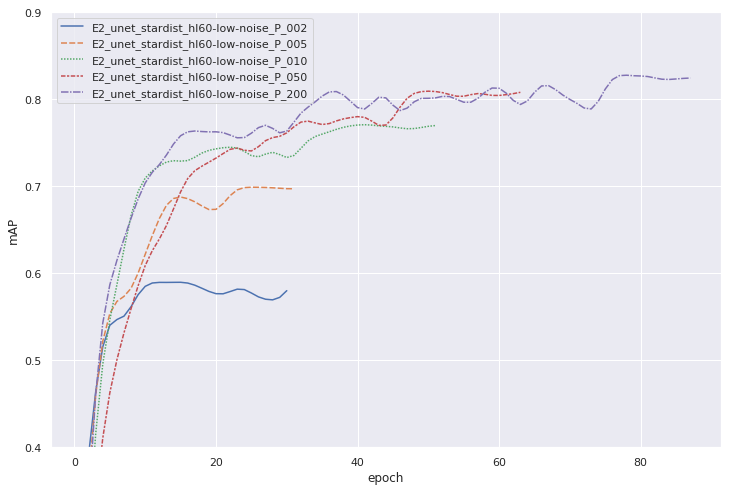

In [11]:
model_dirs_E2_hl60 = [f for f in model_dirs if 'E2' in f and 'hl60' in f and '_P_' in f]
plot_map_over_epoch(get_results_df(model_dirs_E2_hl60))

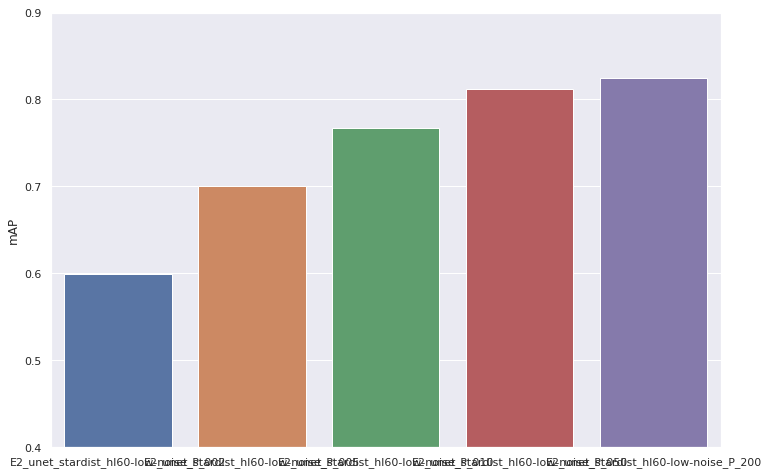

In [12]:
# TODO naming of bars
selected_model_dirs = get_models_for_filters(model_dirs, 'hl60', 'E2')
results_last = get_results_last(selected_model_dirs)
df = pd.DataFrame({n: [v] for n, v in results_last.items()})
ax = sns.barplot(data=df)
ax = ax.set(ylim=(0.4, 0.9), ylabel='mAP')
plt.show()

In [52]:
get_models_for_filters(model_dirs, 'granulocyte', 'E2')

['./models/E2_unet_stardist_granulocyte_P_002',
 './models/E2_unet_stardist_granulocyte_P_005',
 './models/E2_unet_stardist_granulocyte_P_010',
 './models/E2_unet_stardist_granulocyte_P_050',
 './models/E2_unet_stardist_granulocyte_P_200',
 './models/E2_unet_stardist_granulocyte_R_002',
 './models/E2_unet_stardist_granulocyte_R_005',
 './models/E2_unet_stardist_granulocyte_R_010',
 './models/E2_unet_stardist_granulocyte_R_050',
 './models/E2_unet_stardist_granulocyte_R_200',
 './models/E2_unet_stardist_granulocyte_R_F']

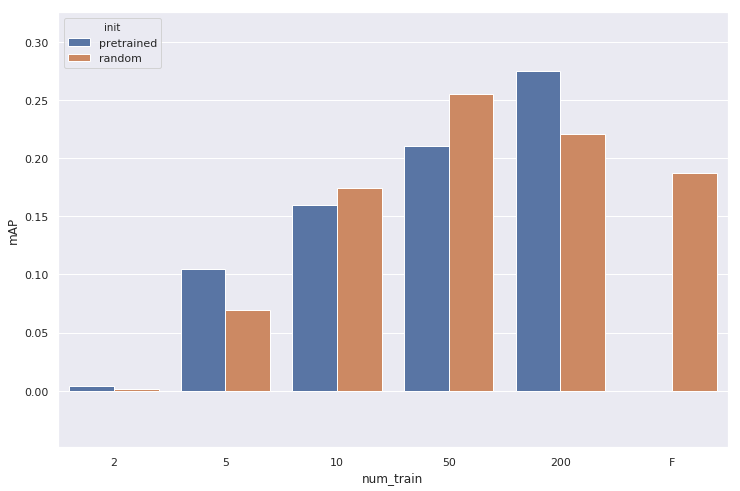

In [65]:
def get_train_num(name):
    num = name.split('_')[-1]
    if num == 'F':
        return 'F'
    else:
        return int(num)
    
def get_init(name):
    return 'pretrained' if name.split('_')[-2] == 'P' else 'random'

selected_model_dirs = get_models_for_filters(model_dirs, 'E5', 'dsb2018')
results_last = get_results_last(selected_model_dirs)
df = pd.DataFrame([{
    'name': n,
    'mAP': v,
    'num_train': get_train_num(n),
    'init': get_init(n)
} for n, v in results_last.items()])

ax = sns.barplot(x='num_train', y='mAP', hue='init', data=df)
ax = ax.set(ylim=(df.min()['mAP'] - 0.05, df.max()['mAP'] + 0.05), ylabel='mAP')
plt.show()